<h1 style="text-align:center">Simluation of a Simple Mass-Spring-Damper System <br> with a Disturbance Force</h1>
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
http://www.ucs.louisiana.edu/~jev9637/   </p>

<p style="text-align:center">
	<img src="http://shared.crawlab.org/MassSpringDamper_SeismicWithDisturbance_Horiz.png" alt="A Mass-Spring-Damper System with a Disturbance Force" width=50%/></a><br>
    <strong> Figure 1: A Mass-Spring-Damper System with a Disturbance Force</strong>
</p>

This notebook simluates a the simple mass-spring-damper model like the one shown in Figure 1. The system has both a position input $y(t)$ and a force input, $f(t)$. This system could also be used to model the position control of a mass via a Proportional Derivative (PD) controller.

The equationof motion for this system is:

$ \quad m\ddot{x} + c \dot{x} + k x = c \dot{y} + k y - f $

We can also rewrie this in terms of damping ratio, $\zeta$, and natural frequency, $\omega_n$:

$ \quad \ddot{x} + 2 \zeta \omega_n \dot{x} + \omega_n^2 x = \zeta \omega_n \dot{y} + \omega_n^2 y - \frac{f}{m} $

However, as we'll see below, we often will collect terms so that our ''motion'' variable are all on the left-hand side, like:

$ \quad \ddot{x} = \frac{k}{m}\left( y - x \right) + \frac{c}{m} \left(\dot{y} - \dot{x} \right) - \frac{f}{m} $


In [1]:
import numpy as np

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
# Import the ODE solver
from scipy.integrate import odeint

## Numba JIT
We're going to try to speed up the ode solution using [Numba](https://numba.pydata.org) [just in time complilation (jit)](http://numba.pydata.org/numba-doc/dev/reference/jit-compilation.html). For this simple system of equations, we might not see real improvements, but several have reported speedups:

* https://gist.github.com/moble/3aa44230256b66956587
* https://stackoverflow.com/questions/42838103/how-can-i-use-cython-well-to-solve-a-differential-equation-faster

In [4]:
from numba import jit

## Functions defining the equations of motion and inputs
We will first define the functions that define the equations of motion and the inputs. One "trick" that we will use is to define $y(t)$ and $\dot{y}(t)$ as states. This allows us to specifiy an acceleration input $\ddot{y}(t)$, which gets propogated to the $y(t)$ and $\dot{y}(t)$ via the equations of motion (or state-transition matrix if we were solving in "true" matrix-based state-space form).

So, we can then define our states as vector $ \bar{w} = \left[x \ \dot{x} \  y \ \dot{y}\right]^T $ and the inputs as $\bar{u} = \left[\ddot{y} \ f \right]$.

Then the system of first-order ODEs we have to solve is:

$ \quad \dot{\bar{w}} = g(\bar{w}, \bar{u}, t) $

Writing these out, we have:

$ \quad \dot{\bar{w}}  = \left[\dot{x} \right.$

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \frac{k}{m}(y - x) + \frac{c}{m}\left(\dot{y} - \dot{x}\right) - \frac{f}{m} $

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \dot{y}$

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \left.\ddot{y}\right]$

Notice that the $\ddot{y}$ in the last line is what we get to specify to generate the position input. In addition to allowing us to only specify one input that gets propograted to y and $\dot{y}$, describing inputs in the acceleration domain is often preferrable. This is because representing a realistic input in this domain is often easier than in the position or velocity domain.

In [5]:
def eq_of_motion(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
        t :  time
        p :  vector of the parameters:
    """
    x, x_dot, y, y_dot = w
    m, k, c, Distance, StartTime, Amax, Vmax, DistStart, F_amp = p

    # Create sysODE = (x', x_dot', y', y_dot')
    sysODE = [x_dot,
             k/m * (y - x) + c/m * (y_dot - x_dot) - f(t, p)/m,
             y_dot,
             y_ddot(t, p)]
    return sysODE


def f(t, p):
    """
    defines the disturbance force input to the system
    """
    m, k, c, Distance, StartTime, Amax, Vmax, DistStart, F_amp = p
    
    # Select one of the two inputs below
    # Be sure to comment out the one you're not using
    
    # Input Option 1: 
    #    Just a step in force beginning at t=DistStart
    # f = F_amp * (t >= DistStart)
    
    # Input Option 2:
    #    A pulse in force beginning at t=DistStart and ending at t=(DistStart+0.1)
    f = F_amp * (t >= DistStart) * (t <= DistStart + 0.1)
    
    return f


def y_ddot(t, p):
    """
    Defines the accel input to the system.
    
    Depending on the desired move distance, max accel, and max velocity, the input is either
    bang-bang or bang-coast-bang
    """
    m, k, c, Distance, StartTime, Amax, Vmax, DistStart, F_amp = p
    
    # These are the times for a bang-coast-bang input 
    t1 = StartTime
    t2 = (Vmax/Amax) + t1
    t3 = (Distance/Vmax) + t1
    t4 = (t2 + t3) - t1
    
    if t3 <= t2: # command should be bang-bang, not bang-coast-bang
        t2 = np.sqrt(Distance/Amax)+t1
        t3 = 2*np.sqrt(Distance/Amax)+t1
        
        accel = Amax*(t > t1) - 2*Amax*(t > t2) + Amax*(t > t3)
    
    else: # command is bang-coast-bang
        accel = Amax*(t > t1) - Amax*(t > t2) - Amax*(t > t3) + Amax*(t > t4)

    return accel

In [6]:
# Define the parameters for simluation
m = 1.0                      # mass (kg)
k = (1.0*2*np.pi)**2             # spring constant (N/m)

wn = np.sqrt(k/m)            # natural frequency (rad/s)

# Select damping ratio and use it to choose an appropriate c
zeta = 0.05                   # damping ratio
c = 2*zeta*wn*m              # damping coeff.

# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.01
stoptime = 10.0
numpoints = 10001

# Create the time samples for the output of the ODE solver
t = np.linspace(0.0,stoptime,numpoints)

# Initial conditions
x_init = 0.0                        # initial position
x_dot_init = 0.0                    # initial velocity
y_init = 0.0
y_dot_init = 0.0

# Set up the parameters for the input function
Distance = 1.0               # Desired move distance (m)
Amax = 20.0                   # acceleration limit (m/s^2)
Vmax = 2.0                   # velocity limit (m/s)
StartTime = 0.5              # Time the y(t) input will begin
DistStart = 4.5              # Time the disturbance input will begin
F_amp = 100.0                 # Amplitude of Disturbance force (N)

# Pack the parameters and initial conditions into arrays 
p = [m, k, c, Distance, StartTime, Amax, Vmax, DistStart, F_amp]
x0 = [x_init, x_dot_init, y_init, y_dot_init]

We'll use the Jupyter Notebook `%timeit` magic to run the solution 10 times and get an average solution time. We simple prepend the code with want to run with `%timeit -n 100 -r 10`, where the `-n 100 -r 10` option specifies the number of times to run the code.

In [7]:
%timeit -n 100 -r 10 odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

21.9 ms ± 846 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [8]:
# Run one more time to store the response
resp = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr, hmax=max_step)

On my MacBook Pro, this solution took about 22ms per loop for 10 runs. 

Now, let's create the Numba jit versions of the functions needed for the differential equations and see how long their soltuion takes.

To do so, we can simply decorate each function with `@jit`. We will also need to make sure that all the parameters any list in the code have the same type (Here, that's the parameter list `p`.). In our case, the only offenders were parameters that used the `numpy.pi` constant, which results in them being type `numpy.float` rather than `float`. The code below corrects that.

In [9]:
for index, i in enumerate(p):
    p[index] = float(i)

In [10]:
@jit
def eq_of_motion(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
        t :  time
        p :  vector of the parameters:
    """
    x, x_dot, y, y_dot = w
    m, k, c, Distance, StartTime, Amax, Vmax, DistStart, F_amp = p

    # Create sysODE = (x', x_dot', y', y_dot')
    sysODE = [x_dot,
             k/m * (y - x) + c/m * (y_dot - x_dot) - f(t, p)/m,
             y_dot,
             y_ddot(t, p)]
    return sysODE

@jit
def f(t, p):
    """
    defines the disturbance force input to the system
    """
    m, k, c, Distance, StartTime, Amax, Vmax, DistStart, F_amp = p
    
    # Select one of the two inputs below
    # Be sure to comment out the one you're not using
    
    # Input Option 1: 
    #    Just a step in force beginning at t=DistStart
    # f = F_amp * (t >= DistStart)
    
    # Input Option 2:
    #    A pulse in force beginning at t=DistStart and ending at t=(DistStart+0.1)
    f = F_amp * (t >= DistStart) * (t <= DistStart + 0.1)
    
    return f

@jit
def y_ddot(t, p):
    """
    Defines the accel input to the system.
    
    Depending on the desired move distance, max accel, and max velocity, the input is either
    bang-bang or bang-coast-bang
    """
    m, k, c, Distance, StartTime, Amax, Vmax, DistStart, F_amp = p
    
    # These are the times for a bang-coast-bang input 
    t1 = StartTime
    t2 = (Vmax/Amax) + t1
    t3 = (Distance/Vmax) + t1
    t4 = (t2 + t3) - t1
    
    if t3 <= t2: # command should be bang-bang, not bang-coast-bang
        t2 = np.sqrt(Distance/Amax)+t1
        t3 = 2*np.sqrt(Distance/Amax)+t1
        
        accel = Amax*(t > t1) - 2*Amax*(t > t2) + Amax*(t > t3)
    
    else: # command is bang-coast-bang
        accel = Amax*(t > t1) - Amax*(t > t2) - Amax*(t > t3) + Amax*(t > t4)

    return accel

Now, let's run the solution using the `%timeit` magic again.

In [11]:
%timeit -n 100 -r 10 odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr, hmax=max_step)

15.8 ms ± 1.74 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


On my oldish MacBook Pro the `@jit` version of the solution averaged $\approx$16ms per loop, about 72% of the time required by the pure Python solution. This is a pretty good speedup for such a simple set of equations and so littel extra work. The improvements should be even higher for more complex systems.

Now, let's print the results to make sure the two methods reached the same solution.

In [12]:
# Run one more time to store the response
resp_jit = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr, hmax=max_step)

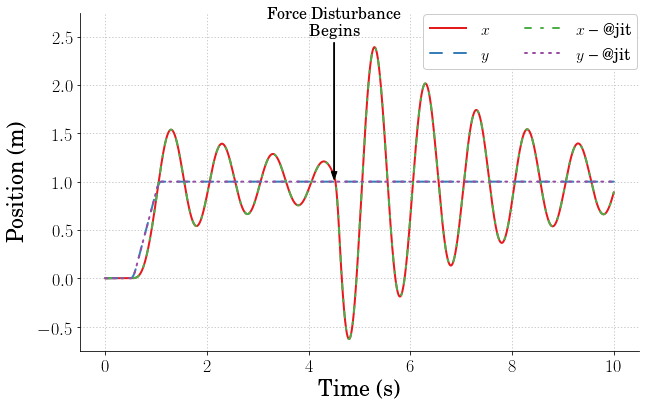

In [13]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel('Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel('Position (m)',family='serif',fontsize=22,weight='bold',labelpad=10)
plt.ylim(-0.75, 2.75)

# plot the response
plt.plot(t,resp[:,0], linewidth=2, linestyle = '-', label=r'$x$')
plt.plot(t,resp[:,2], linewidth=2, linestyle = '--', label=r'$y$')
plt.plot(t,resp_jit[:,0], linewidth=2, linestyle = '-.', label=r'$x$ -- @jit')
plt.plot(t,resp_jit[:,2], linewidth=2, linestyle = ':', label=r'$y$ -- @jit')

# If there is a non-zero force disturbance show where it began via an annotation
if F_amp > 0:
    plt.annotate('Force Disturbance \nBegins',
         xy=(DistStart,resp[-1,2]), xycoords='data',
         ha='center',
         xytext=(DistStart, 1.05*np.max(resp[:,0])), textcoords='data', fontsize=16,
         arrowprops=dict(arrowstyle="simple, head_width = 0.35, tail_width=0.05", connectionstyle="arc3", color="black"),color = "black")
    

leg = plt.legend(loc='upper right', ncol=2, fancybox=True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('MassSpringDamper_Disturbance_Resp.pdf')

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

As we would hope, the two responses match.

<hr class = "style-end">

#### Licenses
Code is licensed under a 3-clause BSD-style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [14]:
# This cell will just improve the styling of the notebook
# You can ignore it, if you are okay with the default sytling
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen("https://cl.ly/1B1y452Z1d35")
HTML(response.read().decode("utf-8"))